# Определению ориентации справки (форма 405) для сервиса DonorSearch

**Цель проекта:**

Нам предстоит разработать сервис, определяющий, правильно ли сориентирована медицинская справка, загруженная пользователем в сервис для доноров DonorSearch.

**Исходные данные:**

Датасет со справками 405 в виде картинок и справками других форм.

**Этапы проекта:**

1. Исследование существующих подходов к решению задачи.
2. Выбор готовой или обучение собственной модели компьютерного зрения для определения ориентации изображения
3. Тестирование модели, определение метрик
4. Подготовка скриптов для препроцессинга изображения, инференса модели и постпроцессинга изображения
5. Создание микросервиса для последующей интеграции в продукт заказчика

Прежде чем загружать датасеты, нужно провести импорт необходимых библиотек.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve
from shutil import copyfile
from PIL import Image
from collections import Counter
from google.colab.patches import cv2_imshow
import shutil
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.models import resnet50, ResNet50_Weights
import time
from time import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.optim import lr_scheduler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Для решения поставленной задачи может использоваться несколько подходов:

1. Обучение собственной модели (это не очень рационально, да и датасет у нас маловат)
2. Дообучение готовой модели, например Resnet, на своих данных.
3. Учитывая, что в дальнейшем (после определения ориентации и поворота на нужный угол) загруженная пользователем справка идет на распознавание текста, логичным будет обучать модель на текстовых блоках, взятых с картинок датасета. Во-первых, мы таким образом значительно увеличим объем данных для обучения модели, а во-вторых сразу сможем отсеять справки с плохим качеством, ведь если на них не определяются текстовые блоки, то значит и распознать текст будет проблематично.

Для детекции текстовых блоков мы взяли готовую модель EAST.

Сначала был реализован следующий алгоритм:
1. Все картинки в исходном датасете были повернуты в правильное положение вручную.
2. В каждой из них с помощью модели EAST были детектированы текстовые блоки и сохранены в картинки.
3. Затем из этих картинок был создан датасет путем поворота каждой картинки с текстовым блоком на углы 0, 90, 180 и 270 градусов.
4. На этом датасете была дообучена модель EfficientNet.
5. Затем прогнали эту модель на справках формы 405, заготовленных отдельно от датасета. Каждую справку поворачивали, определяли на ней текстовые блоки, предсказывали их ориентацию и по большинству предсказаний выбирали итоговую ориентацию всей справки.

# EfficientNet

## Детекция текстовых блоков на исходных данных и создание картинок из блоков

In [ ]:
net = cv2.dnn.readNet('/content/drive/MyDrive/Colab Notebooks/frozen_east_text_detection.pb')

def detect_and_crop_text(image_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    orig = image.copy()
    (H, W) = image.shape[:2]

    (newW, newH) = (640, 640)
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)

    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",  # Для вероятности наличия текста
        "feature_fusion/concat_3"        # Для координат рамок текста
    ]

    (scores, geometry) = net.forward(layerNames)

    (rects, confidences) = decode_predictions(scores, geometry)

    if len(rects) == 0:
        print("No text blocks detected.")
        return

    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    if len(indices) > 0:
        indices = indices.flatten()

        for i in indices:
            (startX, startY, endX, endY) = rects[i]

            if startX < 0 or startY < 0 or endX > W or endY > H:
                print(f"Invalid coordinates: ({startX}, {startY}, {endX}, {endY})")
                continue

            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            cropped_text_block = orig[startY:endY, startX:endX]

            if cropped_text_block.size == 0:
                print(f"Empty cropped text block: ({startX}, {startY}, {endX}, {endY})")
                continue

            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S%f')
            output_path = os.path.join(output_dir, f'text_block_{timestamp}_{i}.png')
            cv2.imwrite(output_path, cropped_text_block)

def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def process_images_in_folder(input_folder, output_folder):
    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    for file_name in files:
        image_path = os.path.join(input_folder, file_name)
        detect_and_crop_text(image_path, output_folder)

process_images_in_folder('/content/drive/MyDrive/Colab Notebooks/images/big', '/content/drive/MyDrive/Colab Notebooks/images/blocks')


Invalid coordinates: (-6, 340, 27, 355)
Invalid coordinates: (-1, 623, 55, 646)
Invalid coordinates: (114, 623, 183, 642)
Invalid coordinates: (67, 622, 127, 642)
Invalid coordinates: (34, 622, 73, 644)
No text blocks detected.
No text blocks detected.
No text blocks detected.
Invalid coordinates: (280, 580, 311, 641)
Invalid coordinates: (119, 517, 145, 660)
No text blocks detected.
No text blocks detected.
No text blocks detected.
Invalid coordinates: (-2, 592, 50, 602)
Invalid coordinates: (571, 510, 641, 525)
Invalid coordinates: (591, 205, 641, 221)
Invalid coordinates: (101, -2, 217, 15)
Invalid coordinates: (264, -2, 477, 13)
No text blocks detected.
Invalid coordinates: (73, -3, 202, 17)
Invalid coordinates: (254, -2, 488, 16)
Invalid coordinates: (249, -6, 495, 11)
Invalid coordinates: (463, -2, 579, 15)
Invalid coordinates: (190, 626, 277, 646)
Invalid coordinates: (242, -2, 464, 16)
Invalid coordinates: (87, 623, 219, 649)
Invalid coordinates: (248, -1, 484, 16)


## Создание датасета, тренировочной и валидационной выборок

In [ ]:
def rotate_image(image, angle):
    """Rotate the image by the given angle."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def create_dataset(input_folder, output_folder):
    """Create a dataset by rotating images and splitting them into train/val folders."""
    orientations = [0, 90, 180, 270]
    for orientation in orientations:
        os.makedirs(os.path.join(output_folder, f'images/{orientation}deg'), exist_ok=True)

    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    for file_name in files:
        image_path = os.path.join(input_folder, file_name)
        image = cv2.imread(image_path)
        for orientation in orientations:
            if orientation == 0:
                rotated_image = image
            else:
                rotated_image = rotate_image(image, orientation)

            output_path = os.path.join(output_folder, f'images/{orientation}deg', file_name)
            cv2.imwrite(output_path, rotated_image)

input_folder = '/content/drive/MyDrive/Colab Notebooks/images/blocks'
output_folder = '/content/drive/MyDrive/Colab Notebooks/images/data'
create_dataset(input_folder, output_folder)

In [ ]:
def split_dataset(base_folder, train_ratio=0.8):
    """Split the dataset into train and validation sets."""
    orientations = [0, 90, 180, 270]
    for orientation in orientations:
        image_folder = os.path.join(base_folder, f'images/{orientation}deg')
        files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
        train_files, val_files = train_test_split(files, test_size=1-train_ratio, random_state=42)

        os.makedirs(os.path.join(base_folder, 'train', f'{orientation}deg'), exist_ok=True)
        os.makedirs(os.path.join(base_folder, 'val', f'{orientation}deg'), exist_ok=True)

        for file_name in train_files:
            src = os.path.join(image_folder, file_name)
            dst = os.path.join(base_folder, 'train', f'{orientation}deg', file_name)
            copyfile(src, dst)

        for file_name in val_files:
            src = os.path.join(image_folder, file_name)
            dst = os.path.join(base_folder, 'val', f'{orientation}deg', file_name)
            copyfile(src, dst)
output_folder = '/content/drive/MyDrive/Colab Notebooks/images/data'
split_dataset(output_folder)

## Обучение модели

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/images/data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/images/data/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.models import EfficientNet_B0_Weights
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 158MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = corrects.double() / total

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/text_orientation_model2.pth')

Epoch 1/20
Loss: 0.9309 Acc: 0.5998
Epoch 2/20
Loss: 0.7030 Acc: 0.6969
Epoch 3/20
Loss: 0.6502 Acc: 0.7160
Epoch 4/20
Loss: 0.6302 Acc: 0.7242
Epoch 5/20
Loss: 0.6104 Acc: 0.7337
Epoch 6/20
Loss: 0.5882 Acc: 0.7454
Epoch 7/20
Loss: 0.6001 Acc: 0.7362
Epoch 8/20
Loss: 0.5622 Acc: 0.7557
Epoch 9/20
Loss: 0.5650 Acc: 0.7515
Epoch 10/20
Loss: 0.5735 Acc: 0.7471
Epoch 11/20
Loss: 0.5798 Acc: 0.7411
Epoch 12/20
Loss: 0.5682 Acc: 0.7480
Epoch 13/20
Loss: 0.5539 Acc: 0.7515
Epoch 14/20
Loss: 0.5678 Acc: 0.7524
Epoch 15/20
Loss: 0.5470 Acc: 0.7568
Epoch 16/20
Loss: 0.5557 Acc: 0.7511
Epoch 17/20
Loss: 0.5463 Acc: 0.7580
Epoch 18/20
Loss: 0.5628 Acc: 0.7536
Epoch 19/20
Loss: 0.5643 Acc: 0.7423
Epoch 20/20
Loss: 0.5607 Acc: 0.7480


In [ ]:
model.eval()
val_loss = 0.0
val_corrects = 0
val_total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        val_corrects += torch.sum(preds == labels.data)
        val_total += labels.size(0)

val_loss /= len(val_dataset)
val_acc = val_corrects.double() / val_total

print(f'Validation Loss: {val_loss:.4f} Accuracy: {val_acc:.4f}')

Validation Loss: 0.4964 Accuracy: 0.7726


In [ ]:
model.eval()

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')

roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')

print(f"Recall (macro): {recall:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"ROC AUC (macro): {roc_auc:.4f}")


Recall (macro): 0.7726
Precision (macro): 0.7744
ROC AUC (macro): 0.9504


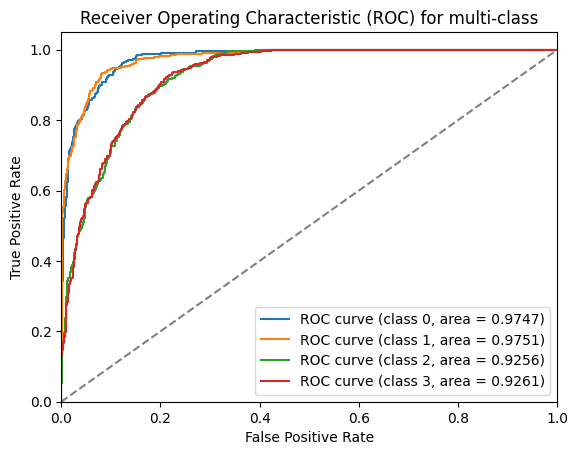

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

n_classes = len(np.unique(y_true))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_prob)[:, i])
    roc_auc[i] = roc_auc_score(np.array(y_true) == i, np.array(y_prob)[:, i])

# Построение графика для всех классов
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}, area = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for multi-class')
plt.legend(loc="lower right")
plt.show()

## Определение ориентации изображений

In [ ]:
net = cv2.dnn.readNet('/content/drive/MyDrive/Colab Notebooks/frozen_east_text_detection.pb')
def detect_and_crop_text(image_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    orig = image.copy()
    (H, W) = image.shape[:2]

    (newW, newH) = (640, 640)
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)

    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",  # Для вероятности наличия текста
        "feature_fusion/concat_3"        # Для координат рамок текста
    ]

    (scores, geometry) = net.forward(layerNames)

    (rects, confidences) = decode_predictions(scores, geometry)

    if len(rects) == 0:
        no=0
        print("No text blocks detected.")
        return no

    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    if len(indices) > 0:
        indices = indices.flatten()

        for i in indices:
            (startX, startY, endX, endY) = rects[i]

            if startX < 0 or startY < 0 or endX > W or endY > H:
                print(f"Invalid coordinates: ({startX}, {startY}, {endX}, {endY})")
                continue

            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            cropped_text_block = orig[startY:endY, startX:endX]

            if cropped_text_block.size == 0:
                print(f"Empty cropped text block: ({startX}, {startY}, {endX}, {endY})")
                continue

            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S%f')
            output_path = os.path.join(output_dir, f'text_block_{timestamp}_{i}.png')
            cv2.imwrite(output_path, cropped_text_block)
            #cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    #cv2_imshow(orig)

def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 4)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/text_orientation_model2.pth', map_location=torch.device('cpu')))
model.eval()

transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
def classify_text_block(image_path):

    image = Image.open(image_path).convert('RGB')
    with torch.no_grad():
        input_tensor = transformer(image).unsqueeze(0)
        input_tensor = input_tensor.to(device)
        model.eval()
        output = model(input_tensor)
        predicted_class = torch.argmax(output, 1).item()

    class_mapping = {0: '0deg', 1: '180deg', 2: '90deg', 3: '270deg'}
    predicted_orientation = class_mapping[predicted_class]
    #print(predicted_orientation)
    return predicted_orientation

def classify_image(model, image_path, output_dir):
    detect_and_crop_text(image_path, output_dir)
    orientations = []
    files = [f for f in os.listdir(output_dir) if f.endswith(".jpg") or f.endswith(".png")]

    if len(files) > 0:

        if len(files) > 10:
            random_files = random.sample(files, 10)
        else:
            random_files = files

        for filename in random_files:
            image_path = os.path.join(output_dir, filename)
            orientation = classify_text_block(image_path)
            orientations.append(orientation)

        most_common_orientation = max(set(orientations), key=orientations.count)
        shutil.rmtree(output_dir)
    else:
        most_common_orientation = 'Пожалуйста, загрузите картинку в лучшем разрешении'

    return most_common_orientation

<ipython-input-18-6977661fdd79>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/text_orientation_mo

In [ ]:
def process_images_in_folder(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            im = Image.open(image_path)
            angle = 0
            out = im.rotate(angle, expand=True)
            out.save('1.png')
            image_path = '1.png'
            orientation = classify_image(model, image_path, output_dir)
            results.append({'image': filename, 'orientation': orientation})

    df = pd.DataFrame(results)
    df.to_csv('orientation_results.csv', index=False)
    print("Results saved to orientation_results.csv")

folder_path = '/content/drive/MyDrive/Colab Notebooks/images/test'
output_dir = '/content/drive/MyDrive/Colab Notebooks/images/temp'
process_images_in_folder(folder_path)
data = pd.read_csv('/content/orientation_results.csv')
data

Invalid coordinates: (-1, 522, 70, 534)
Results saved to orientation_results.csv


,image,orientation
0,photo_5460709214017150821_y.jpg,0deg
1,photo_5460709214017150822_y.jpg,0deg
2,photo_5460709214017150825_y.jpg,0deg
3,photo_5460709214017150826_y.jpg,0deg
4,photo_5460709214017150827_y.jpg,0deg
5,photo_5460709214017150828_y.jpg,0deg
6,photo_5460709214017150828_y_ц.jpg,0deg
7,photo_5460709214017150823_y.jpg,0deg
8,photo_5460709214017150824_y.jpg,0deg
9,photo_5460709214017150824_y_е.jpg,180deg


In [ ]:
data['orientation'].value_counts()

,count
orientation,
0deg,9
180deg,1


In [ ]:
def process_images_in_folder(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            im = Image.open(image_path)
            angle = 90
            out = im.rotate(angle, expand=True)
            out.save('1.png')
            image_path = '1.png'
            orientation = classify_image(model, image_path, output_dir)
            results.append({'image': filename, 'orientation': orientation})

    df = pd.DataFrame(results)
    df.to_csv('orientation_results.csv', index=False)
    print("Results saved to orientation_results.csv")

folder_path = '/content/drive/MyDrive/Colab Notebooks/images/test'
output_dir = '/content/drive/MyDrive/Colab Notebooks/images/temp'
process_images_in_folder(folder_path)
data = pd.read_csv('/content/orientation_results.csv')
data

Invalid coordinates: (-3, 529, 59, 557)
Invalid coordinates: (-2, 158, 74, 183)
Invalid coordinates: (526, 537, 540, 641)
Results saved to orientation_results.csv


,image,orientation
0,photo_5460709214017150821_y.jpg,0deg
1,photo_5460709214017150822_y.jpg,270deg
2,photo_5460709214017150825_y.jpg,90deg
3,photo_5460709214017150826_y.jpg,90deg
4,photo_5460709214017150827_y.jpg,90deg
5,photo_5460709214017150828_y.jpg,270deg
6,photo_5460709214017150828_y_ц.jpg,270deg
7,photo_5460709214017150823_y.jpg,90deg
8,photo_5460709214017150824_y.jpg,90deg
9,photo_5460709214017150824_y_е.jpg,90deg


In [ ]:
data['orientation'].value_counts()

,count
orientation,
90deg,6
270deg,3
0deg,1


In [ ]:
def process_images_in_folder(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            im = Image.open(image_path)
            angle = 180
            out = im.rotate(angle, expand=True)
            out.save('1.png')
            image_path = '1.png'
            orientation = classify_image(model, image_path, output_dir)
            results.append({'image': filename, 'orientation': orientation})

    df = pd.DataFrame(results)
    df.to_csv('orientation_results.csv', index=False)
    print("Results saved to orientation_results.csv")

folder_path = '/content/drive/MyDrive/Colab Notebooks/images/test'
output_dir = '/content/drive/MyDrive/Colab Notebooks/images/temp'
process_images_in_folder(folder_path)
data = pd.read_csv('/content/orientation_results.csv')
data

Invalid coordinates: (582, 82, 643, 94)
Results saved to orientation_results.csv


,image,orientation
0,photo_5460709214017150821_y.jpg,0deg
1,photo_5460709214017150822_y.jpg,0deg
2,photo_5460709214017150825_y.jpg,0deg
3,photo_5460709214017150826_y.jpg,0deg
4,photo_5460709214017150827_y.jpg,0deg
5,photo_5460709214017150828_y.jpg,0deg
6,photo_5460709214017150828_y_ц.jpg,0deg
7,photo_5460709214017150823_y.jpg,0deg
8,photo_5460709214017150824_y.jpg,0deg
9,photo_5460709214017150824_y_е.jpg,0deg


In [ ]:
data['orientation'].value_counts()

,count
orientation,
0deg,10


In [ ]:
def process_images_in_folder(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            im = Image.open(image_path)
            angle = 270
            out = im.rotate(angle, expand=True)
            out.save('1.png')
            image_path = '1.png'
            orientation = classify_image(model, image_path, output_dir)
            results.append({'image': filename, 'orientation': orientation})

    df = pd.DataFrame(results)
    df.to_csv('orientation_results.csv', index=False)
    print("Results saved to orientation_results.csv")

folder_path = '/content/drive/MyDrive/Colab Notebooks/images/test'
output_dir = '/content/drive/MyDrive/Colab Notebooks/images/temp'
process_images_in_folder(folder_path)
data = pd.read_csv('/content/orientation_results.csv')
data

Invalid coordinates: (89, -6, 103, 114)
Results saved to orientation_results.csv


,image,orientation
0,photo_5460709214017150821_y.jpg,270deg
1,photo_5460709214017150822_y.jpg,90deg
2,photo_5460709214017150825_y.jpg,90deg
3,photo_5460709214017150826_y.jpg,90deg
4,photo_5460709214017150827_y.jpg,90deg
5,photo_5460709214017150828_y.jpg,90deg
6,photo_5460709214017150828_y_ц.jpg,270deg
7,photo_5460709214017150823_y.jpg,90deg
8,photo_5460709214017150824_y.jpg,90deg
9,photo_5460709214017150824_y_е.jpg,90deg


In [ ]:
data['orientation'].value_counts()

,count
orientation,
90deg,8
270deg,2


## Вывод

По итогам обучения модели EfficientNet и проверки ее эффективности на справках 405 выяснилось, что модель лучше всего распознает текстовые блоки на справках, повернутых на 0 градусов. Вероятно это связано с тем, что детекция блоков происходила только на картинках, повернутых на 0 градусов. А обучение шло на этих же блоках, но повернутых.

Поэтому для следующей модели мы изменили концепцию. Теперь сначала мы поворачиваем исходные данные, а потом проводим детекцию текстовых блоков, на которых и будем дообучать модель Resnet.

# Resnet50

## Детекция текстовых блоков

In [ ]:
def rotate_image(image, angle):
    """Rotate the image by the given angle."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def create_dataset(input_folder, output_folder):
    """Create a dataset by rotating images and splitting them into train/val folders."""
    orientations = [0, 90, 180, 270]
    for orientation in orientations:
        os.makedirs(os.path.join(output_folder, f'{orientation}deg'), exist_ok=True)

    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    for file_name in files:
        image_path = os.path.join(input_folder, file_name)
        image = cv2.imread(image_path)
        for orientation in orientations:
            if orientation == 0:
                rotated_image = image
            else:
                rotated_image = rotate_image(image, orientation)

            output_path = os.path.join(output_folder, f'{orientation}deg', file_name)
            cv2.imwrite(output_path, rotated_image)

input_folder = '/content/drive/MyDrive/Colab Notebooks/images/big'
output_folder = '/content/drive/MyDrive/Colab Notebooks/images/data_new'
create_dataset(input_folder, output_folder)

In [ ]:
net = cv2.dnn.readNet('/content/drive/MyDrive/Colab Notebooks/frozen_east_text_detection.pb')

def detect_and_crop_text(image_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    orig = image.copy()
    (H, W) = image.shape[:2]

    (newW, newH) = (640, 640)
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)

    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",  # Для вероятности наличия текста
        "feature_fusion/concat_3"        # Для координат рамок текста
    ]

    (scores, geometry) = net.forward(layerNames)

    (rects, confidences) = decode_predictions(scores, geometry)

    if len(rects) == 0:
        print("No text blocks detected.")
        return

    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    if len(indices) > 0:
        indices = indices.flatten()

        for i in indices:
            (startX, startY, endX, endY) = rects[i]

            if startX < 0 or startY < 0 or endX > W or endY > H:
                print(f"Invalid coordinates: ({startX}, {startY}, {endX}, {endY})")
                continue

            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            cropped_text_block = orig[startY:endY, startX:endX]

            if cropped_text_block.size == 0:
                print(f"Empty cropped text block: ({startX}, {startY}, {endX}, {endY})")
                continue

            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S%f')
            output_path = os.path.join(output_dir, f'text_block_{timestamp}_{i}.png')
            cv2.imwrite(output_path, cropped_text_block)

def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def process_images_in_folder(input_folder, output_folder):
    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    for file_name in files:
        image_path = os.path.join(input_folder, file_name)
        detect_and_crop_text(image_path, output_folder)

process_images_in_folder('/content/drive/MyDrive/Colab Notebooks/images/data_new/270deg', '/content/drive/MyDrive/Colab Notebooks/images/blocks_new/270deg')
process_images_in_folder('/content/drive/MyDrive/Colab Notebooks/images/data_new/180deg', '/content/drive/MyDrive/Colab Notebooks/images/blocks_new/180deg')
process_images_in_folder('/content/drive/MyDrive/Colab Notebooks/images/data_new/90deg', '/content/drive/MyDrive/Colab Notebooks/images/blocks_new/90deg')
process_images_in_folder('/content/drive/MyDrive/Colab Notebooks/images/data_new/0deg', '/content/drive/MyDrive/Colab Notebooks/images/blocks_new/0deg')

Invalid coordinates: (-11, 529, 19, 543)
Invalid coordinates: (-26, 526, 22, 546)
Invalid coordinates: (-1, 470, 42, 482)
Invalid coordinates: (-3, 205, 32, 254)
Invalid coordinates: (-4, 478, 76, 493)
Invalid coordinates: (-2, 500, 18, 537)
Invalid coordinates: (-2, 512, 74, 529)
No text blocks detected.
Invalid coordinates: (406, -5, 424, 94)
Invalid coordinates: (286, 482, 304, 641)
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
Invalid coordinates: (191, -2, 203, 80)
Invalid coordinates: (467, 568, 488, 652)
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
No text blocks detected.
Invalid coordinates: (318, -1, 337, 24)
Invalid coordi

## обучение модели

In [ ]:
dataDir = '/content/drive/MyDrive/Colab Notebooks/images/blocks_new'

folders = ['270deg', '180deg', '90deg', '0deg']
CLASSES = {'270deg': 0,
           '180deg': 1,
           '90deg': 2,
           '0deg':3
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224

generator = torch.Generator().manual_seed(1001)
transformer = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != 'RGB' else img),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
class spravka(torch.utils.data.Dataset):
    def __init__(self, root, label, transform):
        self.root = root
        self.label = label
        self.transforms = transform
        self.imgs = os.listdir(os.path.join(self.root, self.label))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.label, self.imgs[idx])
        img = Image.open(img_path)
        target = CLASSES[self.label]

        return self.transforms(img), torch.tensor(target), self.label

    def __len__(self):
        return len(self.imgs)


In [ ]:
data_1 = spravka(dataDir, folders[0], transformer)
data_2 = spravka(dataDir, folders[1], transformer)
data_3 = spravka(dataDir, folders[2], transformer)
data_4 = spravka(dataDir, folders[3], transformer)
print(f'classes size: \n {folders[0]} -- {len(data_1)} \n {folders[1]} -- {len(data_2)} \n {folders[2]} -- {len(data_3)} \n {folders[3]} -- {len(data_4)} \n')
data_spravka = ConcatDataset([data_1, data_2, data_3, data_4])
train, valid, test = torch.utils.data.random_split(data_spravka, [.6, .2, .2], generator=generator)
print(f"train - {len(train)} \n valid - {len(valid)} \n test - {len(test)}")

classes size: 
 270deg -- 1068 
 180deg -- 3861 
 90deg -- 942 
 0deg -- 4991 

train - 6518 
 valid - 2172 
 test - 2172


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels, _ in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels, _ in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train, criterion, opt, sch)

            val_loss, val_acc = eval_epoch(model, val, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Set requires_grad = False for all parameters
for param in resnet.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(resnet.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 4
resnet.fc = nn.Linear(in_features, out_features)
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 39.1MB/s]


In [ ]:
ce = nn.CrossEntropyLoss()
lr = 3e-4

In [ ]:
history = train(train_dataloader, valid_dataloader, model=resnet, epochs=10, rate=lr, criterion=ce)

epoch:  10%|█         | 1/10 [40:40<6:06:06, 2440.73s/it]


Epoch 001 train_loss: 0.8082     val_loss 0.7326 train_acc 0.5718 val_acc 0.6174


epoch:  20%|██        | 2/10 [42:44<2:23:40, 1077.61s/it]


Epoch 002 train_loss: 0.5587     val_loss 0.6256 train_acc 0.7396 val_acc 0.7215


epoch:  30%|███       | 3/10 [44:41<1:14:35, 639.34s/it]


Epoch 003 train_loss: 0.3810     val_loss 0.9142 train_acc 0.8320 val_acc 0.6846


epoch:  40%|████      | 4/10 [46:38<43:18, 433.01s/it]


Epoch 004 train_loss: 0.2767     val_loss 0.5789 train_acc 0.8869 val_acc 0.7592


epoch:  50%|█████     | 5/10 [48:27<26:21, 316.27s/it]


Epoch 005 train_loss: 0.1726     val_loss 0.5834 train_acc 0.9354 val_acc 0.7739


epoch:  60%|██████    | 6/10 [50:27<16:37, 249.41s/it]


Epoch 006 train_loss: 0.0776     val_loss 0.5653 train_acc 0.9762 val_acc 0.7951


epoch:  70%|███████   | 7/10 [52:19<10:13, 204.56s/it]


Epoch 007 train_loss: 0.0347     val_loss 0.6014 train_acc 0.9937 val_acc 0.7970


epoch:  80%|████████  | 8/10 [54:20<05:55, 177.95s/it]


Epoch 008 train_loss: 0.0202     val_loss 0.6198 train_acc 0.9971 val_acc 0.7993


epoch:  90%|█████████ | 9/10 [56:13<02:37, 157.61s/it]


Epoch 009 train_loss: 0.0152     val_loss 0.6523 train_acc 0.9983 val_acc 0.7942


epoch: 100%|██████████| 10/10 [58:12<00:00, 349.21s/it]


Epoch 010 train_loss: 0.0116     val_loss 0.6649 train_acc 0.9980 val_acc 0.8011


In [ ]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [ ]:
from matplotlib import pyplot as plt
def vizualize(h, model):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model)
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(model)
    plt.show()

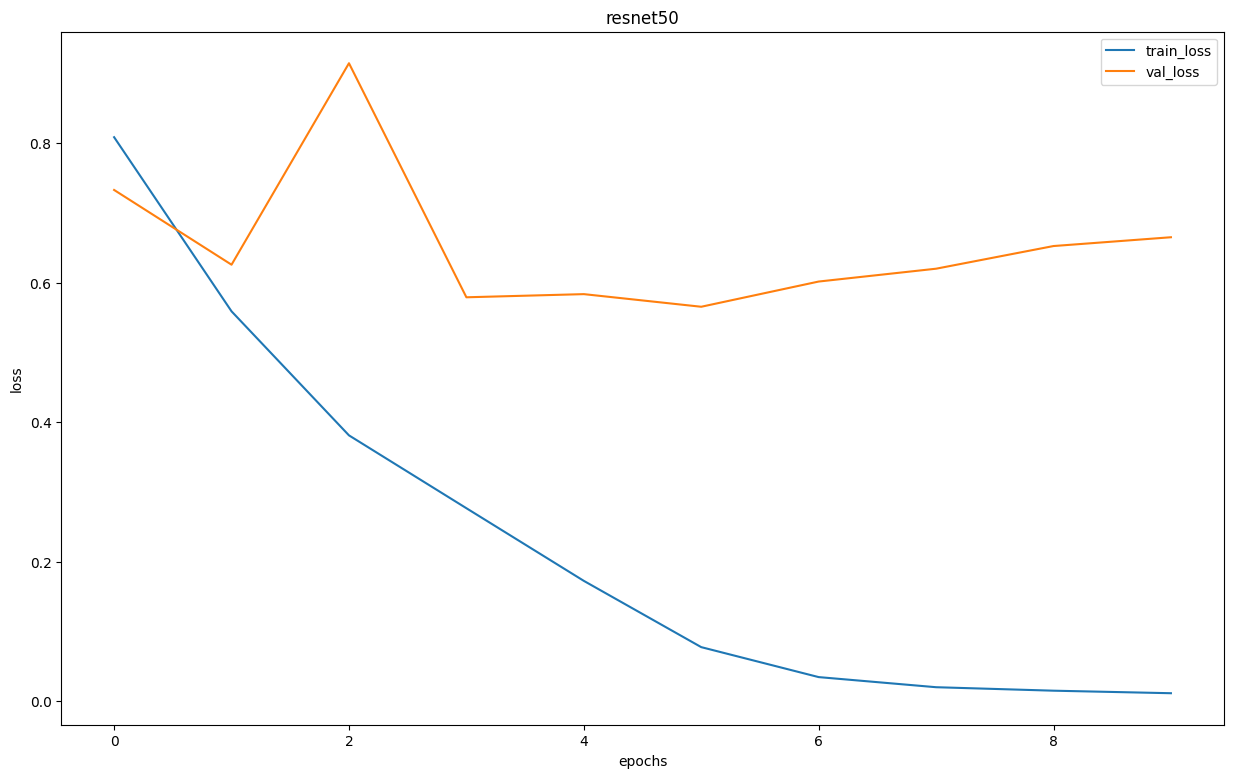

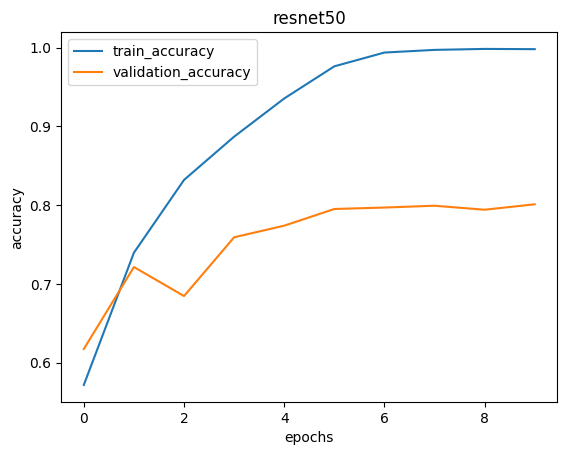

In [ ]:
vizualize(history, 'resnet50')

In [ ]:
result_1 = predict(resnet, test_dataloader)

In [ ]:
print(f'Test Accuracy for resnet50 -- {result_1[3]:.2}')

Test Accuracy for resnet50 -- 0.8


In [ ]:
result = result_1

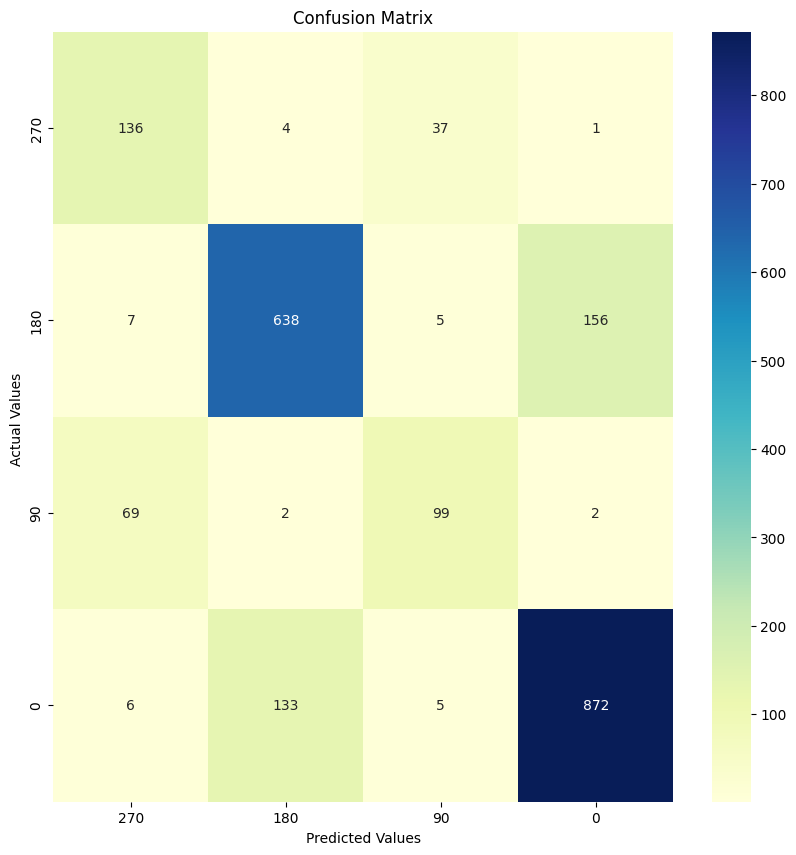

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['270','180', '90', '0'])
ax.yaxis.set_ticklabels(['270','180', '90', '0'])
plt.show()

In [ ]:
torch.save(resnet.state_dict(), '/content/drive/MyDrive/Colab Notebooks/resnet_4.pth')


Так как лучше всего блоки детектируются при ориентации 0 и 180 градусов, соответствено модель получила больше всего материала для обучения именно для этих двух ориентаций, поэтому с 90 и 270 градусами справляется хуже.

В идеале нужно увеличить датасет, чтобы улучшить предсказания модели на 90 и 270 градусов. Но в связи с нехваткой времени на проект придется воспользоваться костылем.

Поэтому при определении ориентации изображений по блокам будет разумно дополнительно поворачивать картинку при предсказании 90 и 270 градусов для повышения точности. Но есть и минус - дополнительно будет тратиться время.

## Определение ориентации изображений

In [ ]:
net = cv2.dnn.readNet('/content/drive/MyDrive/Colab Notebooks/frozen_east_text_detection.pb')
def detect_and_crop_text(image_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    orig = image.copy()
    (H, W) = image.shape[:2]

    (newW, newH) = (640, 640)
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)

    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",  # Для вероятности наличия текста
        "feature_fusion/concat_3"        # Для координат рамок текста
    ]

    (scores, geometry) = net.forward(layerNames)

    (rects, confidences) = decode_predictions(scores, geometry)

    if len(rects) == 0:
        no=0
        print("No text blocks detected.")
        return no

    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    if len(indices) > 0:
        indices = indices.flatten()

        for i in indices:
            (startX, startY, endX, endY) = rects[i]

            if startX < 0 or startY < 0 or endX > W or endY > H:
                print(f"Invalid coordinates: ({startX}, {startY}, {endX}, {endY})")
                continue

            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            cropped_text_block = orig[startY:endY, startX:endX]

            if cropped_text_block.size == 0:
                print(f"Empty cropped text block: ({startX}, {startY}, {endX}, {endY})")
                continue

            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S%f')
            output_path = os.path.join(output_dir, f'text_block_{timestamp}_{i}.png')
            cv2.imwrite(output_path, cropped_text_block)
            #cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    #cv2_imshow(orig)

def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_features = 2048
out_features = 4
model = resnet50(weights=None)
model.fc = nn.Linear(in_features, out_features)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/resnet_4.pth', map_location=device))
model = model.to(device)
model.eval()

transformer = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != 'RGB' else img),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def classify_text_block(image_path):

    image = Image.open(image_path).convert('RGB')
    with torch.no_grad():
        input_tensor = transformer(image).unsqueeze(0)
        input_tensor = input_tensor.to(device)
        model.eval()
        output = model(input_tensor)
        predicted_class = torch.argmax(output, 1).item()

    class_mapping = {0: '270deg', 1: '180deg', 2: '90deg', 3: '0deg'}
    predicted_orientation = class_mapping[predicted_class]
    #print(predicted_orientation)
    return predicted_orientation

def classify_image(model, image_path, output_dir):
    detect_and_crop_text(image_path, output_dir)
    orientations = []
    files = [f for f in os.listdir(output_dir) if f.endswith(".jpg") or f.endswith(".png")]

    if len(files) > 0:

        if len(files) > 20:
            random_files = random.sample(files, 20)
        else:
            random_files = files
        #random_files = files
        for filename in random_files:
            image_path = os.path.join(output_dir, filename)
            orientation = classify_text_block(image_path)
            orientations.append(orientation)

        most_common_orientation = max(set(orientations), key=orientations.count)
        shutil.rmtree(output_dir)
    else:
        most_common_orientation = 'Пожалуйста, загрузите картинку в лучшем разрешении'

    return most_common_orientation

<ipython-input-86-77ad33d1776e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/resnet_4.pth', map_

In [ ]:
output_dir = '/content/drive/MyDrive/Colab Notebooks/images/temp'
image_path = '/content/drive/MyDrive/Colab Notebooks/images/big/405___83a46dc4d8554fecae624a5422028422.png'
im = Image.open(image_path)
angle = 180
out = im.rotate(angle, expand=True)
out.save('1.png')
image_path = '1.png'
predicted_orientation = classify_image(model, image_path, output_dir)
print(f'Predicted orientation: {predicted_orientation}')

Predicted orientation: 180deg


In [ ]:
def process_images_in_folder(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            im = Image.open(image_path)
            angle = 0
            out = im.rotate(angle, expand=True)
            out.save('1.png')
            image_path = '1.png'
            orientation = classify_image(model, image_path, output_dir)
            results.append({'image': filename, 'orientation': orientation})

    df = pd.DataFrame(results)
    df.to_csv('orientation_results.csv', index=False)
    print("Results saved to orientation_results.csv")

folder_path = '/content/drive/MyDrive/Colab Notebooks/images/test'
output_dir = '/content/drive/MyDrive/Colab Notebooks/images/temp'
process_images_in_folder(folder_path)
data = pd.read_csv('/content/orientation_results.csv')
data

Invalid coordinates: (-1, 522, 70, 534)
Results saved to orientation_results.csv


,image,orientation
0,photo_5460709214017150821_y.jpg,0deg
1,photo_5460709214017150822_y.jpg,0deg
2,photo_5460709214017150825_y.jpg,0deg
3,photo_5460709214017150826_y.jpg,0deg
4,photo_5460709214017150827_y.jpg,0deg
5,photo_5460709214017150828_y.jpg,0deg
6,photo_5460709214017150828_y_ц.jpg,0deg
7,photo_5460709214017150823_y.jpg,0deg
8,photo_5460709214017150824_y.jpg,0deg
9,photo_5460709214017150824_y_е.jpg,0deg


In [ ]:
data['orientation'].value_counts()

,count
orientation,
0deg,10


In [ ]:
def process_images_in_folder(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            im = Image.open(image_path)
            angle = 90
            out = im.rotate(angle, expand=True)
            out.save('1.png')
            image_path = '1.png'
            orientation = classify_image(model, image_path, output_dir)
            if (orientation == '270deg') or (orientation == '90deg'):
              out2 = out.rotate(90, expand=True)
              out2.save('2.png')
              image_path = '2.png'
              orientation = classify_image(model, image_path, output_dir)
            results.append({'image': filename, 'orientation': orientation})

    df = pd.DataFrame(results)
    df.to_csv('orientation_results.csv', index=False)
    print("Results saved to orientation_results.csv")

folder_path = '/content/drive/MyDrive/Colab Notebooks/images/test'
output_dir = '/content/drive/MyDrive/Colab Notebooks/images/temp'
process_images_in_folder(folder_path)
data = pd.read_csv('/content/orientation_results.csv')
data

Invalid coordinates: (-3, 529, 59, 557)
Invalid coordinates: (-2, 158, 74, 183)
Invalid coordinates: (526, 537, 540, 641)
Invalid coordinates: (582, 82, 643, 94)
Results saved to orientation_results.csv


,image,orientation
0,photo_5460709214017150821_y.jpg,180deg
1,photo_5460709214017150822_y.jpg,0deg
2,photo_5460709214017150825_y.jpg,180deg
3,photo_5460709214017150826_y.jpg,180deg
4,photo_5460709214017150827_y.jpg,0deg
5,photo_5460709214017150828_y.jpg,180deg
6,photo_5460709214017150828_y_ц.jpg,180deg
7,photo_5460709214017150823_y.jpg,180deg
8,photo_5460709214017150824_y.jpg,180deg
9,photo_5460709214017150824_y_е.jpg,180deg


In [ ]:
data['orientation'].value_counts()

,count
orientation,
90deg,7
270deg,3


In [ ]:
def process_images_in_folder(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            im = Image.open(image_path)
            angle = 180
            out = im.rotate(angle, expand=True)
            out.save('1.png')
            image_path = '1.png'
            orientation = classify_image(model, image_path, output_dir)
            results.append({'image': filename, 'orientation': orientation})

    df = pd.DataFrame(results)
    df.to_csv('orientation_results.csv', index=False)
    print("Results saved to orientation_results.csv")

folder_path = '/content/drive/MyDrive/Colab Notebooks/images/test'
output_dir = '/content/drive/MyDrive/Colab Notebooks/images/temp'
process_images_in_folder(folder_path)
data = pd.read_csv('/content/orientation_results.csv')
data

Invalid coordinates: (582, 82, 643, 94)
Results saved to orientation_results.csv


,image,orientation
0,photo_5460709214017150821_y.jpg,180deg
1,photo_5460709214017150822_y.jpg,0deg
2,photo_5460709214017150825_y.jpg,180deg
3,photo_5460709214017150826_y.jpg,180deg
4,photo_5460709214017150827_y.jpg,0deg
5,photo_5460709214017150828_y.jpg,180deg
6,photo_5460709214017150828_y_ц.jpg,180deg
7,photo_5460709214017150823_y.jpg,180deg
8,photo_5460709214017150824_y.jpg,180deg
9,photo_5460709214017150824_y_е.jpg,180deg


In [ ]:
data['orientation'].value_counts()

,count
orientation,
180deg,8
0deg,2


In [ ]:
def process_images_in_folder(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            im = Image.open(image_path)
            angle = 270
            out = im.rotate(angle, expand=True)
            out.save('1.png')
            image_path = '1.png'
            orientation = classify_image(model, image_path, output_dir)
            if (orientation == '270deg') or (orientation == '90deg'):
              out2 = out.rotate(90, expand=True)
              out2.save('2.png')
              image_path = '2.png'
              orientation = classify_image(model, image_path, output_dir)
            results.append({'image': filename, 'orientation': orientation})

    df = pd.DataFrame(results)
    df.to_csv('orientation_results.csv', index=False)
    print("Results saved to orientation_results.csv")

folder_path = '/content/drive/MyDrive/Colab Notebooks/images/test'
output_dir = '/content/drive/MyDrive/Colab Notebooks/images/temp'
process_images_in_folder(folder_path)
data = pd.read_csv('/content/orientation_results.csv')
data

Invalid coordinates: (89, -6, 103, 114)
Invalid coordinates: (-1, 522, 70, 534)
Results saved to orientation_results.csv


,image,orientation
0,photo_5460709214017150821_y.jpg,0deg
1,photo_5460709214017150822_y.jpg,0deg
2,photo_5460709214017150825_y.jpg,0deg
3,photo_5460709214017150826_y.jpg,0deg
4,photo_5460709214017150827_y.jpg,0deg
5,photo_5460709214017150828_y.jpg,0deg
6,photo_5460709214017150828_y_ц.jpg,0deg
7,photo_5460709214017150823_y.jpg,0deg
8,photo_5460709214017150824_y.jpg,0deg
9,photo_5460709214017150824_y_е.jpg,0deg


In [ ]:
data['orientation'].value_counts()

,count
orientation,
0deg,10


# Вывод

Таким образом мы провели определенные исследования (за кадром осталось обучение модели Resnet на большом датасете с Кагла из сканированных документов, где точность модели приближалась к 98%, однако на справках 405 эта модель сильно ошибалась), попробовали два разных подхода, но основанных на одном принципе - детекция текстовых блоков.

Подход с поворотом картинок, последующей детекцией, а затем обучением модели на этих блоках получился более успешным. И хотя точность модели вышла около 80% (вероятно из-за недостаточного количества в датасете блоков, повернутых на 90 и 270 градусов), при определении ориентации целых изображений модель практически не ошибается на картинках 0 и 180 градусов (потому что на одной картинке детектируется от 10 до 40 текстовых блоков, а итоговая ориентация определяется по большинству, что значительно повышает точность предсказания).

К сожалению, пришлось добавлять дополнительный поворот, если модель предсказывает 90 или 270 градусов (этого можо избежать, если дообучить модель).

Главный минус всей концепции - это то, что определение ориентации идет достаточно долго из-за предварительной детекции текстовых блоков и последующего определения их ориентации. Для ускорения работы мы ограничили число текстовых блоков, для которых определеяется ориентация.

Главный плюс - из-за предварительной детекции текстовых блоков можно сразу забраковать некачественные картинки или картинки без текста, то есть не являющиеся справками, что повысит точность последующего распознавания текста.